<h2> Задача: </h2>

Решить уравнение Лапласа в прямоугольнике $\left[ 0 , 4\right] \times  \left[ 0 , 2\right]$

$
\begin{cases}
   \Delta \varphi (x, y)  = 0, \\
   \varphi (x, 0) = \varphi (0, y) = \varphi (4, y) = 0, \\
   \varphi (x, 2) = 10.
\end{cases}
$


Точное решение:

$
\displaystyle
\varphi\left(x, y\right) = \sum_{n = 1}^{\infty} \dfrac{20 \left(1 - (-1)^n \right)}{\pi n \left[ exp\left({-\dfrac{\pi n}{2}}\right) - exp\left({\dfrac{\pi n}{2}}\right)  \right]} \left[ exp\left({-\dfrac{\pi n}{4}} y \right) -  exp\left({\dfrac{\pi n}{4}} y \right)  \right] \sin{\left( \dfrac{\pi n}{4} x \right)}
$

In [29]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import numpy as np
from numba import njit
import time

export_path = "./latex/illustr/domain_rectangle_dirichlet_only/"
# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements, linewidth: float = 0.2):
    # print(nodes_x)
    it = 0
    for element in elements:
        x = [nodes_x[element[0]], nodes_x[element[1]], nodes_x[element[2]]]
        y = [nodes_y[element[0]], nodes_y[element[1]], nodes_y[element[2]]]
        # print(x , y)
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1

@njit()
def exact_solution(x, y, row_num_el: int = 250):
    res = 0
    for n in range(1, row_num_el + 1):
        res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * y ) - np.exp( np.pi * n / 4 * y)) * np.sin(np.pi * n / 4 * x)
    return res

def print_mean_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        error_in_node.append( np.fabs( z[i] - exact_solution(x[i], y[i]) ))
    print("Mean error: ", round(np.mean(error_in_node), 8))
    print("Max error: ", round(np.max(error_in_node), 8))



def print_mear_rel_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        z_exact = exact_solution(x[i], y[i])
        if np.fabs(z_exact) > 1e-9:
            error_in_node.append( np.divide(np.fabs( z[i] - z_exact ) , z_exact) )
    print("Mean rel error: ", round(np.mean(error_in_node), 8))



<h1> True sol

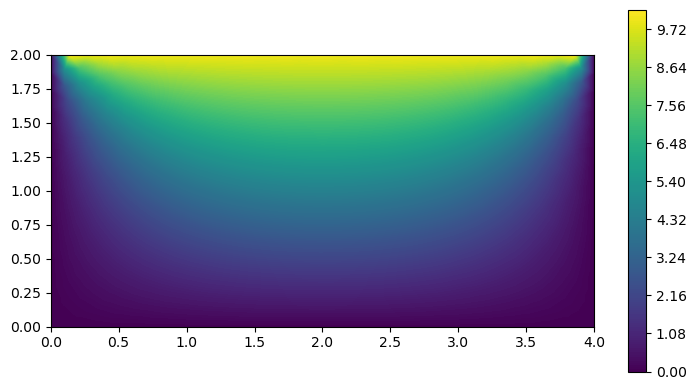

In [21]:
df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z_exact = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;
for i in range(len(df_z_exact["sol"].values)):
    df_z_exact["sol"].values[i] = exact_solution(df_x_y["x"].values[i], df_x_y["y"].values[i])


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z_exact["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + "rect_dirichlet_only_exact_sol.png", dpi = 500, transparent=True)
plt.show()


<h2> Численное решение </h2>

<h1> Rectangle domain (normal cell 0.05)

0.70565149 0.71428571 1.92249706 1.89671349 0.02578357 0.0134115
3.79021072 1.79689642 5.04479917 4.36588939 0.67890978 0.13457618
2.0 0.24565203 1.02955191 1.20047438 0.17092247 0.16601637
2.30769231 0.17049592 0.69845102 0.83962825 0.14117723 0.20212904
3.0592947 1.80003042 8.41313988 8.38443712 0.02870276 0.00341166
Mean rel error:  0.14326178
Mean error:  0.2409948
Max error:  2.00116537


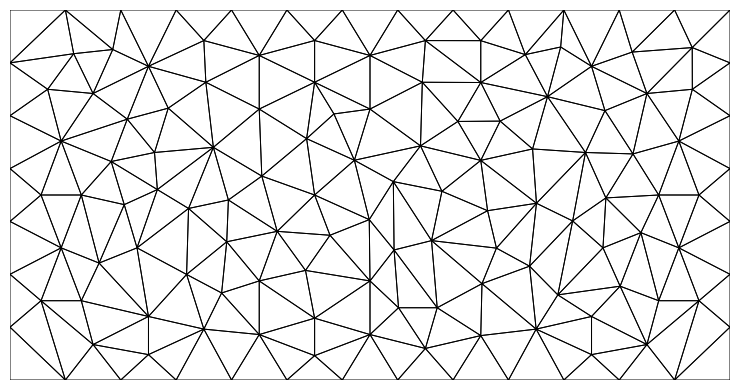

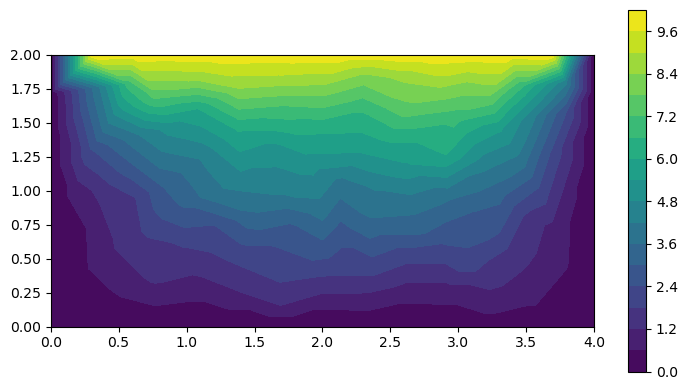

In [31]:
domain_name = "rect_dirichlet_only_005"

df_x_y = pd.read_csv("./domains/domain_2/mesh005/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh005/Test_domain_2_rectangle_dirichlet_only_005_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh005/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8), round(z_exact, 8), round(df_z["sol"].values[k], 8), round(np.fabs(z_exact - df_z["sol"].values[k]) , 8), round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8))


k = 40
pr_er(k)

k = 60
pr_er(k)

k = 80
pr_er(k)

k = 100
pr_er(k)

k = 140
pr_er(k)


print_mear_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_mean_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.xlim(0, 4)
plt.ylim(0, 2)
plt.axis('off')
plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)
plt.show()
plt.close()



plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 17)


plt.axis("image")
plt.colorbar()
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
plt.show()


<h1> Rectangle domain (small cell 0.01)

0.23366363 0.86666667 0.92024967 1.03627587 0.1160262 0.12608121
3.79522734 0.46074876 0.37867336 0.45343056 0.0747572 0.19741869
0.663541 0.88058667 2.37307293 2.57656468 0.20349175 0.08575031
0.68030636 0.42008395 1.03698103 1.08130487 0.04432384 0.04274316
Mean rel error:  0.07227057
Mean error:  0.13261515
Max error:  1.14213676


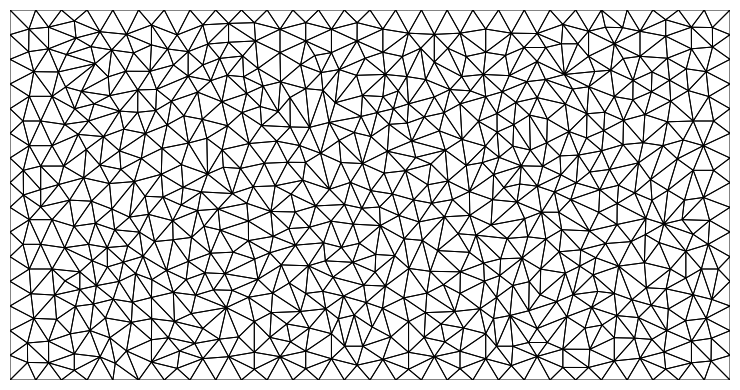

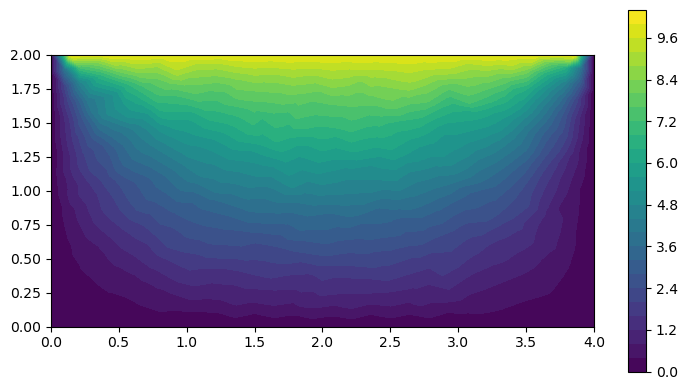

In [32]:
domain_name = "rect_dirichlet_only_001"

df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8), round(z_exact, 8), round(df_z["sol"].values[k], 8), round(np.fabs(z_exact - df_z["sol"].values[k]) , 8), round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8))


k = 100
pr_er(k)

k = 200
pr_er(k)

k = 300
pr_er(k)

k = 400
pr_er(k)

print_mear_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_mean_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.xlim(0, 4)
plt.ylim(0, 2)
plt.axis('off')
plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 25)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
plt.show()

1.81928956 1.90187664 9.41722314 9.45391342 0.03669028 0.00389608
3.77952568 0.21185966 0.18053213 0.19849845 0.01796632 0.09951871
2.21328848 1.65646601 7.97069116 7.97896546 0.0082743 0.00103809
1.59853336 0.85423037 3.6372332 3.57186013 0.06537307 0.0179733
Mean rel error:  0.03652789
Mean error:  0.05903798
Max error:  1.33034943


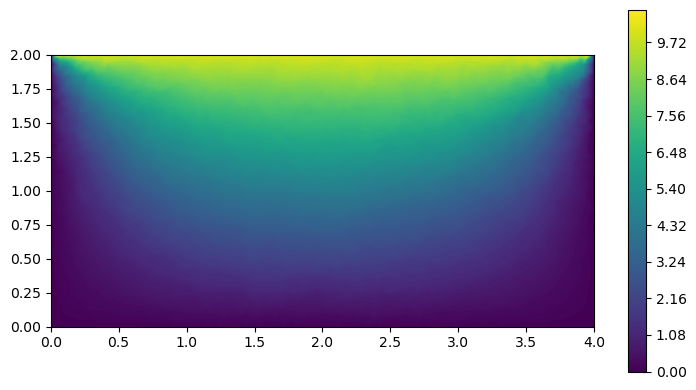

In [33]:
domain_name = "rect_dirichlet_only_0001"

df_x_y = pd.read_csv("./domains/domain_2/mesh0001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh0001/Test_domain_2_rectangle_dirichlet_only_0001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh0001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8), round(z_exact, 8), round(df_z["sol"].values[k], 8), round(np.fabs(z_exact - df_z["sol"].values[k]) , 8), round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8))

k = 1000
pr_er(k)

k = 2000
pr_er(k)

k = 3000
pr_er(k)

k = 4000
pr_er(k)

print_mear_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_mean_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

# plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)
# plt.xlim(0, 4)
# plt.ylim(0, 2)
# plt.axis('off')
# plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)

plt.show()
plt.close()


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()